# Summary of Findings

### Introduction
In this project, I use the data on 12,000 civilian complaints filed against New York City police officers. With that, I want to investigate whether the length that the complaint is opend depend on the ethnicity of the complainant. For this purpose, I mainly look at the duration between the received time and close time for each complaint and the ethnicity of the complainant, which are all included in the dataset.

### Cleaning and EDA
Noticing that certain fields have "missing" data that isn't labeled as missing, for example, there are fields with the value "Unknown" in "complainant_ethnicity", I convert them to null values. Since I want to look at the duration between the received time and close time for each case, I then combine the receive date related columns to create datetime object for receive date, and similarly for close time as well.


### Assessment of Missingness
After a close view, I find there are many missing values for ethnicity, which may affect my hypothesis test. Therefore, I want to investigate whether the missingness of complainant's ethnicity depends on other columns. I investigate whether the missingness of complainant ethnicity depends on the gender of the complainant at first, and with a p-value of 0.0, I reject the null hypothesis. Therefore, it is unlikely that the missingness of ethnicity of complainants is independent of their gender. It is likely that the missingness of ethnicity of complainants is MAR on complaintant gender, and so the observed data may be biased, which will influence my hypothesis test. I also look at "precinct" for which missingness of complainant ethnicity may not depend on, and I get a p-value of 0.104, which makes me fail to reject the null hypothesis, so it is likely that missingness of complainant ethnicity does not depend on the precinct.


### Hypothesis Test
I perform a hypothesis test to see whether the length that the complaint is open depends on the ethnicity of complainant:

- Null Hypothesis: The length that the complaint is open is independent on ethnicity of complainant
- Althernative Hypothesis: The length that the complaint is open is dependent on ethnicity of complainant

The test statistic I use is KS statistic, and I use a significance level of 95%. I get a p-value of 1.3190706275596996e-24 < 0.05 which is extremely small, so that it gives me confidence to reject the null hypothesis and so it is not likely that the length that the complaint is open is independent of the ethnicity of complaintant.


# NYPD Civilian Complaints


### Getting the Data

In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
df = pd.read_csv('data/allegations_202007271729.csv')

# Code

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA


First, have a look at the data set and the columns it contains:

In [4]:
df.head(3)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)


In [5]:
df.columns

Index(['unique_mos_id', 'first_name', 'last_name', 'command_now', 'shield_no',
       'complaint_id', 'month_received', 'year_received', 'month_closed',
       'year_closed', 'command_at_incident', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_now', 'rank_incident', 'mos_ethnicity',
       'mos_gender', 'mos_age_incident', 'complainant_ethnicity',
       'complainant_gender', 'complainant_age_incident', 'fado_type',
       'allegation', 'precinct', 'contact_reason', 'outcome_description',
       'board_disposition'],
      dtype='object')

After further exploration, I find some cells are filled with "Unknown" in "complainant_ethnicity" column as shown below, so I convert them to null values for convenience.

In [6]:
df[df.complainant_ethnicity == 'Unknown'].head(3)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
63,10039,Willie,Johnson,079 DET,4446,9702,8,2005,9,2006,...,33,Unknown,Male,23.0,Force,Physical force,75.0,Other,Arrest - other violation/crime,Exonerated
167,10085,Keith,Chatterton,079 PCT,7323,7520,4,2004,3,2005,...,29,Unknown,Male,40.0,Force,Pepper spray,79.0,Report-dispute,No arrest made or summons issued,Unsubstantiated
222,10137,Ted,Holway,079 PCT,17225,19822,1,2010,11,2010,...,25,Unknown,Male,21.0,Abuse of Authority,Stop,72.0,NaN,No arrest made or summons issued,Unsubstantiated


In [7]:
# Replace unknown with null values
df = df.replace('Unknown', np.NaN)

Now let's have a look at the values in "complainant_ethnicity" column:

In [8]:
df.complainant_ethnicity.value_counts()

Black              17114
Hispanic            6424
White               2783
Other Race           677
Asian                532
Refused              259
American Indian       64
Name: complainant_ethnicity, dtype: int64

Visualization of the distribution of complaintant ethinicity:

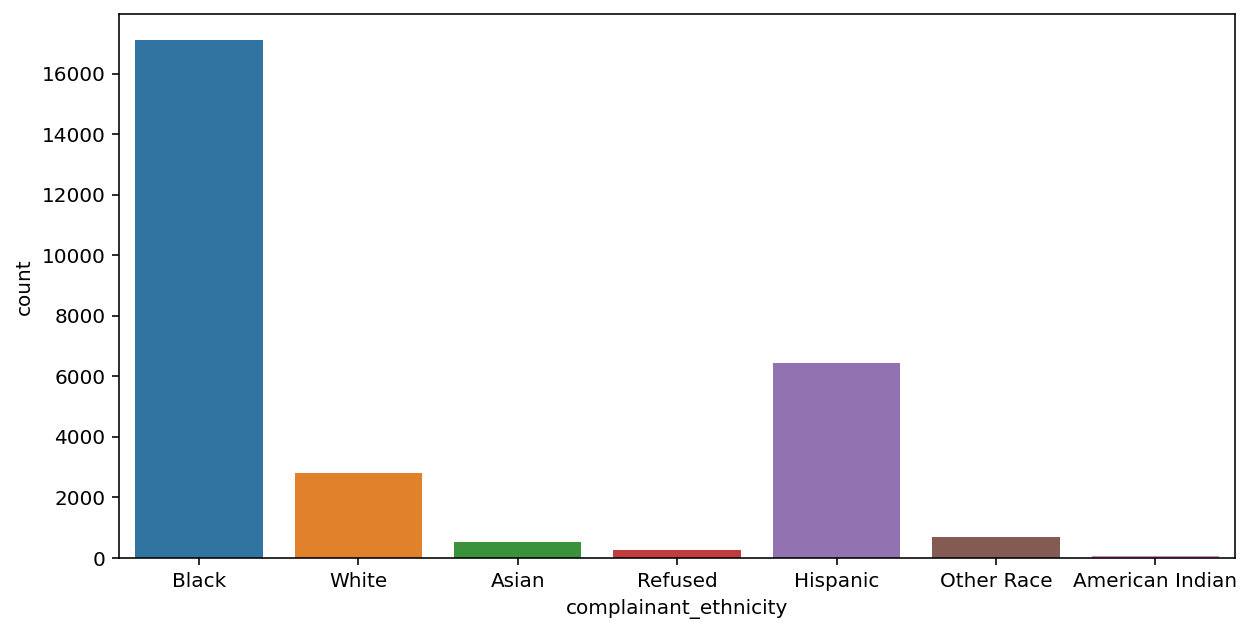

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(x = df.complainant_ethnicity, data = df);

Notice that most complaintants are Black, follwed by Hispanic, then White from the countplot.

Then I combine the receive date related columns to create datetime object for receive date, and similarly for close time as well so that I can compute the length of open time later.

In [10]:
# Combine receive date related columns to create datetime object for receive date
receive = df[['month_received', 'year_received']]
receive = receive.rename(columns = {'month_received' : 'month' , 'year_received' : 'year'})
receive = receive.assign(day = 1)
receive_date = pd.to_datetime(receive[["month", "year","day"]])
df = df.assign(receive_date = receive_date)

# Combine close date related columns to create datetime object for close date
close = df[['month_closed', 'year_closed']]
close = close.rename(columns = {'month_closed' : 'month' , 'year_closed' : 'year'})
close = close.assign(day = 1)
close_date = pd.to_datetime(close[["month", "year","day"]])
df = df.assign(close_date = close_date)

Now I can compute the length of open time for each complaint based on "receive_date" and "close_date", and add a column "open_length" to the dataset:

In [11]:
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,receive_date,close_date
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions),2019-07-01,2020-05-01
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges),2012-07-01,2013-09-01
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A),2018-08-01,2019-02-01


In [12]:
df.groupby('mos_gender').shield_no.nunique().idxmax()

'M'

Visualize the length of open time:

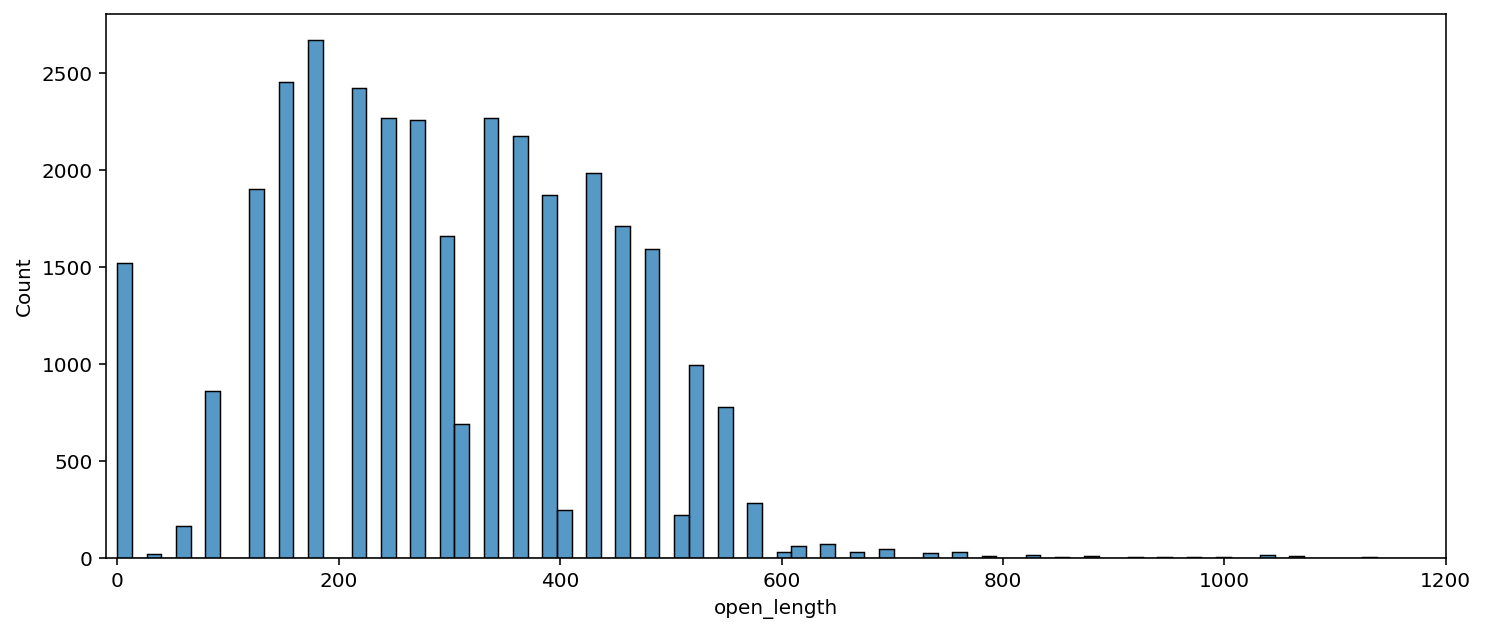

In [12]:
days = df.open_length.dt.days
plt.figure(figsize=(12,5))
plt.xlim(xmin = -10, xmax = 1200)
sns.histplot(x = days);

Notice from the histplot that most of the complains have a open time between 0 - 500 days.

Groupby complainant ethnicity and compute the average open days for each ethnic groups, and notice that Black complainant have longer open length on average than other groups:

In [44]:
df.groupby('complainant_ethnicity')['open_days'].aggregate(np.mean).sort_values()

complainant_ethnicity
Asian              258.345865
Refused            265.722008
American Indian    271.093750
White              284.872080
Other Race         291.090103
Hispanic           308.947385
Black              320.058607
Name: open_days, dtype: float64

Visualize the length of open time among each ethnic groups:

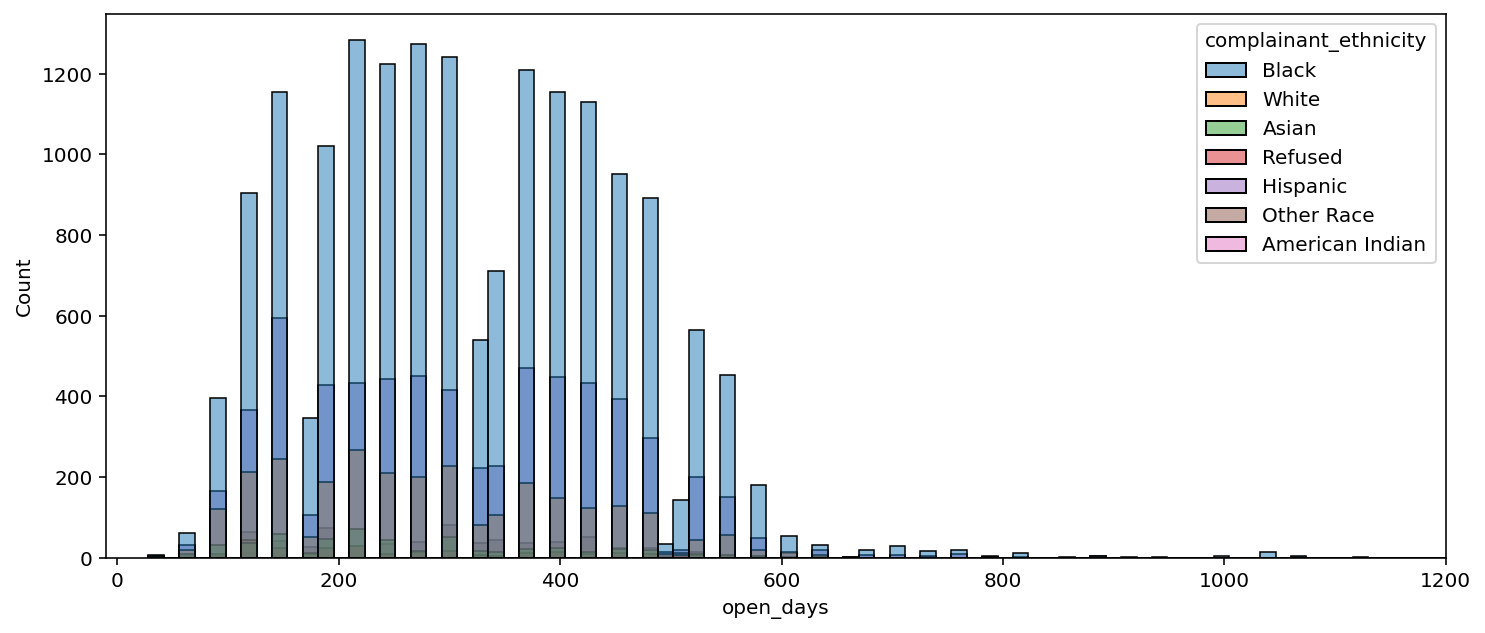

In [13]:
df['open_days'] = days
plt.figure(figsize=(12,5))
plt.xlim(xmin = -10, xmax = 1200)
sns.histplot(x = 'open_days', hue = 'complainant_ethnicity', data =df);



### Assessment of Missingness

First take a look at missingness for each column:

In [14]:
df.isnull().sum()

unique_mos_id                  0
first_name                     0
last_name                      0
command_now                    0
shield_no                      0
complaint_id                   0
month_received                 0
year_received                  0
month_closed                   0
year_closed                    0
command_at_incident         1544
rank_abbrev_incident           0
rank_abbrev_now                0
rank_now                       0
rank_incident                  0
mos_ethnicity                  0
mos_gender                     0
mos_age_incident               0
complainant_ethnicity       5505
complainant_gender          4195
complainant_age_incident    4812
fado_type                      0
allegation                     1
precinct                      24
contact_reason               199
outcome_description           56
board_disposition              0
receive_date                   0
close_date                     0
open_length                    0
open_days 

#### Permutaion Test on Missingness of complaintant ethnicity:

1. After a close look, I find that there are many missing values for complaintant ethnicity. Therefore, I want to investigate whether the missingness of comlaintant ethnicity depends on the gender of the complainant. Maybe ethnicity is a more private topic for specific gender, so that they do not want to report their ethnicity accordingly. Therefore, I would assume that missingness of complainant ethnicity depends on complainant gender at first, and then run a permutation test to see the result.


- H0: The missingness of "complaintant_ethnicity" is independent of "complainant_gender".
- H1: The missingness of "complaintant_ethnicity" depends on "complainant_gender".

I use TVD as the test statistic, since gender is a qualitative variable. I use the significance level of 95%.

In [4]:
subdf = df.copy()[['complainant_ethnicity', 'complainant_gender']]

I exclude complaintant who refuse to report their ethnicity, since the value "Refused" is meaningless in our permutation test, and then I create a bool column for missingness of ethnicity:

In [5]:
subdf = subdf[subdf['complainant_ethnicity']!='Refused']
subdf = subdf.assign(**{'eth_is_null' : subdf['complainant_ethnicity'].isnull()})
subdf.head()

,complainant_ethnicity,complainant_gender,eth_is_null
0,Black,Female,False
1,Black,Male,False
2,Black,Male,False
3,Black,Male,False
4,NaN,NaN,True


Compute the empirical distribution:

In [6]:
emp_distributions = (
    subdf
    .pivot_table(columns='eth_is_null', index='complainant_gender', aggfunc='size')
    .fillna(0)
    .apply(lambda x:x / x.sum())
)
emp_distributions

eth_is_null,False,True
complainant_gender,,
Female,0.171408,0.204861
Gender non-conforming,0.000070,0.000000
Male,0.826076,0.784722
Not described,0.001573,0.010417
Transman (FTM),0.000175,0.000000
Transwoman (MTF),0.000699,0.000000


In [8]:
subdf.pivot_table(columns='eth_is_null', index='complainant_gender', aggfunc='size').apply(lambda x:x / x.sum())

eth_is_null,False,True
complainant_gender,,
Female,0.171408,0.204861
Gender non-conforming,0.000070,NaN
Male,0.826076,0.784722
Not described,0.001573,0.010417
Transman (FTM),0.000175,NaN
Transwoman (MTF),0.000699,NaN


I generate a bar plot to visualize the missingness of "complainant_ethnicity" among all gender groups:

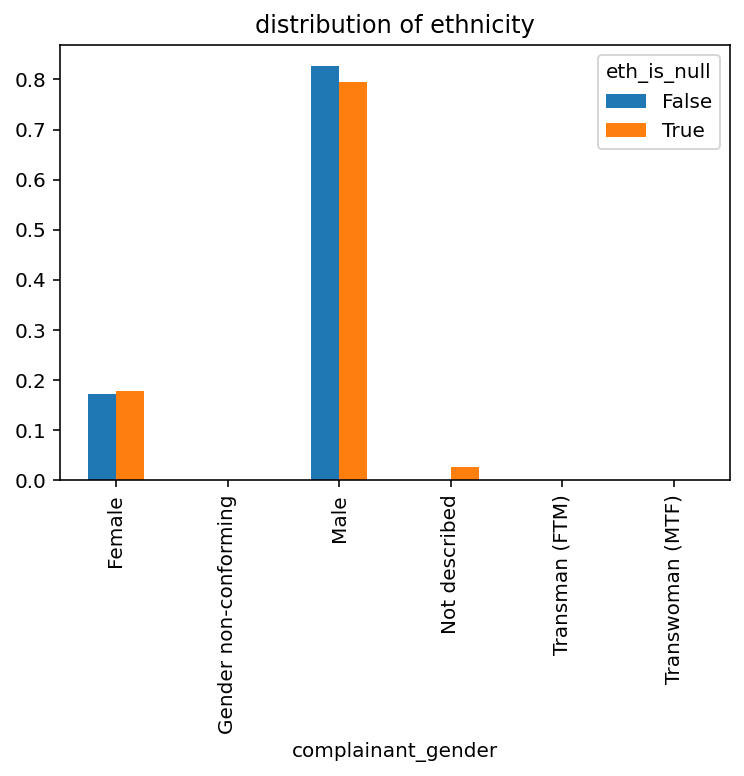

In [18]:
emp_distributions.plot(kind='barh', title='distribution of ethnicity');

Run simluation 500 times and compute the tvds:

In [19]:
n_repetitions = 500

tvds = []
for _ in range(n_repetitions):
    
    # shuffle the genders
    shuffled_types = (
        subdf['complainant_gender']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (
        subdf
        .assign(**{'Shuffled Types': shuffled_types})
    )
    
    # compute the tvd
    shuffed_emp_distributions = (
        shuffled
        .pivot_table(columns='eth_is_null', index='Shuffled Types', values=None, aggfunc='size')
        .fillna(0)
        .apply(lambda x:x/x.sum())
    )
    
    tvd = np.sum(np.abs(shuffed_emp_distributions.diff(axis=1).iloc[:,-1])) / 2
    # add it to the list of results
    
    tvds.append(tvd)

Compute the observed tvd:

In [20]:
observed_tvd = np.sum(np.abs(emp_distributions.diff(axis=1).iloc[:,-1])) / 2
observed_tvd

0.03214140286122733

Compute the p-value:

In [21]:
pval = np.count_nonzero(tvds >= observed_tvd) / len(tvds)
pval

0.0

Visualize the distribution and the observed tvd and notice that the probability of observing the observed tvd is extremely small:

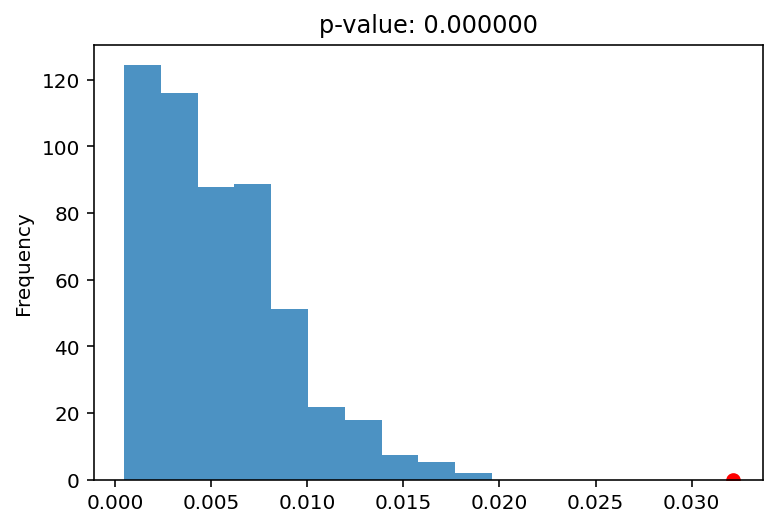

In [22]:
# Generate histogram
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)
plt.scatter(observed_tvd, 0, color='red', s=40);

Obtaining a p-value of 0.0 gives me confidence to reject the null hypothesis. Therefore, it is unlikely that the missingness of ethnicity of complaintants is independent of their gender. Since missingness of ethnicity of complaintants is MAR on the gender of complaintant, it is likely that the observed data is biased, which may influence the significance of our hypothesis test later.

2. Then I also want to look at "precinct" column, for which I think missingness of complaintant ethnicity may not depend on.

- H0: The missingness of "complaintant_ethnicity" is independent of "precinct".
- H1: The missingness of "complaintant_ethnicity" depends on "precinct".

I use TVD as the test statistic, since precinct is a qualitative variable after I make them into 4 main precincts later. I use the significance level of 95%.

In [23]:
subdf = df.copy()[['complainant_ethnicity', 'precinct']]

Have a look at the summary of the precinct values:

In [24]:
subdf['precinct'].describe()

count    33334.000000
mean        64.365213
std         31.451592
min          0.000000
25%         43.000000
50%         67.000000
75%         81.000000
max       1000.000000
Name: precinct, dtype: float64

Observe that most of the precinct values are between 43-81, so I make bins on precinct values from 40-80 with 4 bins with equal size and only look at these precincts:

In [25]:
bins = [40, 50, 60, 70, 80]
subdf = subdf.copy()[(subdf['precinct'] <= 80) & (subdf['precinct'] >= 40)]
subdf['binned_precinct'] = pd.cut(subdf['precinct'], bins)
subdf.head()

,complainant_ethnicity,precinct,binned_precinct
0,Black,78.0,"(70, 80]"
1,Black,67.0,"(60, 70]"
2,Black,67.0,"(60, 70]"
3,Black,67.0,"(60, 70]"
4,NaN,67.0,"(60, 70]"


I exclude complaintant who refuse to report their ethnicity and create a bool column for missingness of ethnicity as before:

In [26]:
subdf = subdf[subdf['complainant_ethnicity'] != 'Refused']
subdf = subdf.assign(**{'eth_is_null' : subdf['complainant_ethnicity'].isnull()})
subdf.head()

,complainant_ethnicity,precinct,binned_precinct,eth_is_null
0,Black,78.0,"(70, 80]",False
1,Black,67.0,"(60, 70]",False
2,Black,67.0,"(60, 70]",False
3,Black,67.0,"(60, 70]",False
4,NaN,67.0,"(60, 70]",True


Compute the empirical distribution:

In [28]:
emp_distributions = (
    subdf
    .pivot_table(columns='eth_is_null', index='binned_precinct', aggfunc='size')
    .fillna(0)
    .apply(lambda x:x / x.sum())
)
emp_distributions.head()

eth_is_null,False,True
binned_precinct,,
"(40, 50]",0.375983,0.352922
"(50, 60]",0.071567,0.064048
"(60, 70]",0.183092,0.206339
"(70, 80]",0.369358,0.376692


I generate a bar plot to visualize the missingness of "complainant_ethnicity" among the 4 precinct groups that I am interested in:

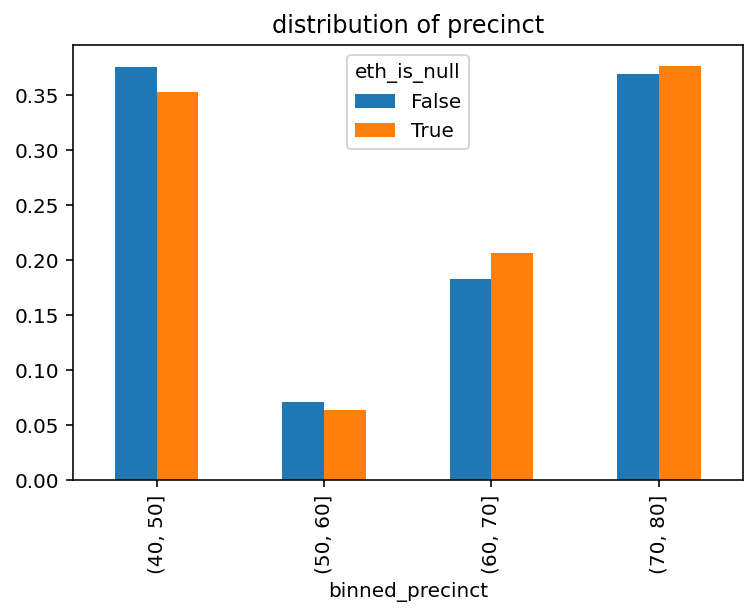

In [29]:
emp_distributions.plot(kind='bar', title='distribution of precinct');

Run simluation 500 times and compute the tvds:

In [30]:
n_repetitions = 500

tvds = []
for _ in range(n_repetitions):
    
    # shuffle the precinct groups
    shuffled_types = (
        subdf['binned_precinct']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # put them in a table
    shuffled = (subdf.assign(**{'Shuffled Types': shuffled_types}))
    
    # compute the tvd
    shuffed_emp_distributions = (
        shuffled
        .pivot_table(columns='eth_is_null', index='Shuffled Types', values=None, aggfunc='size')
        .fillna(0)
        .apply(lambda x:x/x.sum())
    )
    
    tvd = np.sum(np.abs(shuffed_emp_distributions.diff(axis=1).iloc[:,-1])) / 2
    # add it to the list of results
    
    tvds.append(tvd)

Compute observed tvd:

In [31]:
observed_tvd = np.sum(np.abs(emp_distributions.diff(axis=1).iloc[:,-1])) / 2
observed_tvd

0.030580737708933263

Compute p-value:

In [32]:
pval = np.count_nonzero(tvds >= observed_tvd) / len(tvds)
pval

0.104

Visualize the distribution and the observed tvd and notice that it is very likely to have the observed tvd:

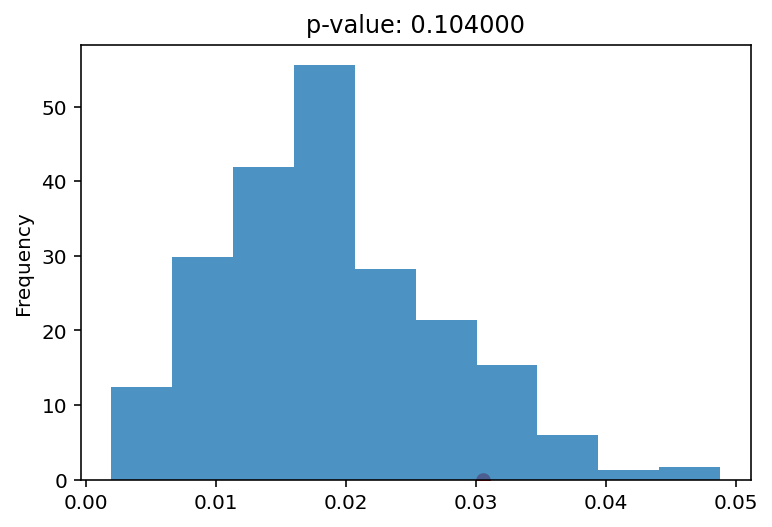

In [33]:
# Generate histogram
pd.Series(tvds).plot(kind='hist', density=True, alpha=0.8, title='p-value: %f' % pval)
plt.scatter(observed_tvd, 0, color='red', s=40);

Obtaining a p-value of 0.104 > 0.05 makes me fail to reject the null hypothesis. Therefore, it is likely that the missingness of ethnicity of complaintants is independent of the precinct.

### Hypothesis Test

I perform a hypothesis test to see whether the length that the complaint is open depends on ethnicity of the complainant. I mainly consider Black and White groups:

- Null Hypothesis: The length that the complaint is open is independent of the ethnicity (Black / White) of complainant
- Althernative Hypothesis: The length that the complaint is open is dependent of the ethnicity (Black / White) of complainant


The test statistic I use is KS statistic, since I want to measure the simliarity of distributions of open length, which is a quatitative variable, between Black and White group. I use a significance level of 95%.

Have a look at the values of 'complainant_ethnicity':

In [34]:
df['complainant_ethnicity'].value_counts()

Black              17114
Hispanic            6424
White               2783
Other Race           677
Asian                532
Refused              259
American Indian       64
Name: complainant_ethnicity, dtype: int64

Take groups of Black and White and perform KS test, and obtain the observed KS statistic:

In [35]:
black = df.loc[df['complainant_ethnicity'] == 'Black', 'open_length']
white = df.loc[df['complainant_ethnicity'] == 'White', 'open_length']

obs = ks_2samp(black, white).statistic
obs

0.1076324389078065

Compute the p-value:

In [36]:
p_val = ks_2samp(black, white)[1]
p_val

1.3190706275596996e-24

Here, I get a p-value of 1.3190706275596996e-24 < 0.05 which is extremely small, so that it gives me confidence to reject the null hypothesis and so it is not likely that the length that the complaint is open is independent of the ethnicity of complaintant. 

However, the result of my hypothesis test has uncertainty in it, since the missingness of complaintant ethnicity is MAR on complaintant gender, so that the observed data may be biased, which limits the significance of the hypothesis test. Also, since I only take White and Black ethnicity into account, there may be other confounding factors such as gender or age of the complaintant that may affect the open length that may need some further investigations.